In [1]:
from pathlib import Path
import os
import pandas as pd
import sys
import requests
from functools import partial
from tqdm import tqdm

import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch 
from einops import rearrange, repeat
from loguru import logger
from torchmetrics import Metric, BootStrapper
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import seaborn as sns
from matplotlib.pyplot import figure
from cka import gram, centering_mat, centered_gram, unbiased_hsic_xy, MinibatchCKA, HookedCache, make_pairwise_metrics, update_metrics, get_simmat_from_metrics
import numpy as np
import re

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import timm
from timm.utils import accuracy
from torch.utils.tensorboard import SummaryWriter

from get_models import get_model

writer = SummaryWriter()

DEVICE = torch.device('cpu')
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')

### Create ImageNet validation dataset

In [2]:
# using the validation transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])

## Randomly subsample features too

data_path='/datasets01/imagenet_full_size/061417/'
dataset = torchvision.datasets.ImageFolder(data_path + 'val', transform=transform)

In [3]:
data_loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=128,
                                        shuffle=False,
                                        pin_memory=False)

log_every = 10
do_log = True

### Load pre-trained DINO, Moco-v3, MAE with linear classifiers

In [4]:
vitb16_dino = get_model('DINO', 'linear')
vitb16_mae = get_model('MAE', 'linear')
vitb16_mocov3 = get_model('MoCo-V3', 'linear')
vitb16_dino_ft = get_model('DINO', 'finetuned')
vitb16_mae_ft = get_model('MAE', 'finetuned')
vitb16_mocov3_ft = get_model('MoCo-V3', 'finetuned')
vitb16_supervised = get_model('Supervised')

Using cache found in /private/home/sshkhr/.cache/torch/hub/facebookresearch_dino_main
/private/home/sshkhr/.conda/envs/pytorch_env/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Using cache found in /private/home/sshkhr/.cache/torch/hub/facebookresearch_dino_main


In [ ]:
vitb16_dino.to(DEVICE)
vitb16_mae.to(DEVICE)
vitb16_mocov3.to(DEVICE)
vitb16_dino_ft.to(DEVICE)
vitb16_mae_ft.to(DEVICE)
vitb16_mocov3_ft.to(DEVICE)
vitb16_supervised.to(DEVICE)

vitb16_supervised.eval()
vitb16_dino.eval()
vitb16_mae.eval()
vitb16_mocov3.eval()
vitb16_dino_ft.eval()
vitb16_mae_ft.eval()
vitb16_mocov3_ft.eval()

### Validate on ImageNet test set

In [6]:
def validate(dataloader, model, device):

    results = torch.zeros(len(dataloader.dataset), 2)
    rankings = torch.zeros(len(dataloader.dataset), 1000)

    with torch.no_grad():
        
        # use with one image per batch
        for it, [batch, target] in enumerate(tqdm(dataloader)):
            batch = batch.to(device)
            target = target.to(device)
            output = model(batch)
            
            batch_size = target.size(0)

            
            _, pred = output.topk(5, 1, True, True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))
            
            results[it*batch_size:(it+1)*batch_size, 0] = correct[:1].view(-1).float() 
            results[it*batch_size:(it+1)*batch_size, 1] = correct[:5].sum(0).view(-1).float()
            

            _, rankings[it*batch_size:(it+1)*batch_size, :] = output.topk(1000, 1, True, True)

    return results, rankings

In [ ]:
moco_results, moco_ranks = validate(data_loader, vitb16_mocov3, DEVICE)

In [ ]:
dino_results, dino_ranks = validate(data_loader, vitb16_dino, DEVICE)

In [ ]:
mae_results, mae_ranks = validate(data_loader, vitb16_mae, DEVICE)

In [ ]:
moco_results_ft, moco_ranks_ft = validate(data_loader, vitb16_mocov3_ft, DEVICE)

In [ ]:
dino_results_ft, dino_ranks_ft = validate(data_loader, vitb16_dino_ft, DEVICE)

In [ ]:
mae_results_ft, mae_ranks_ft = validate(data_loader, vitb16_mae_ft, DEVICE)

In [ ]:
supervised_results, supervised_ranks = validate(data_loader, vitb16_supervised, DEVICE)

In [11]:
dic = {'supervised': [supervised_results, supervised_ranks],
       'MAE': [mae_results, mae_ranks],
       'DINO': [dino_results, dino_ranks],
       'MoCo-V3': [moco_results, moco_ranks],
       'MAE-FT': [mae_results_ft, mae_ranks_ft],
       'DINO-FT': [dino_results_ft, dino_ranks_ft],
       'MoCo-V3-FT': [moco_results_ft, moco_ranks_ft],
        }

import pickle

pickle.dump(dic, open("ranks_and_results.pkl", "wb" ))

In [4]:
import pickle

with open('ranks_and_results.pkl', 'rb') as f:
    dic = pickle.load(f)

In [5]:
supervised_results, supervised_ranks = dic['supervised']
mae_results, mae_ranks = dic['MAE']
dino_results, dino_ranks = dic['DINO']
moco_results, moco_ranks = dic['MoCo-V3']
mae_results_ft, mae_ranks_ft = dic['MAE-FT']
dino_results_ft, dino_ranks_ft = dic['DINO-FT']
moco_results_ft, moco_ranks_ft = dic['MoCo-V3-FT']


## Compare results

In [11]:
print(moco_results[:, 0].sum()/50000., moco_results[:, 1].sum()/50000.)
print(dino_results[:, 0].sum()/50000., dino_results[:, 1].sum()/50000.) # looks like DINO linear model didn't load correctly
print(mae_results[:, 0].sum()/50000., mae_results[:, 1].sum()/50000.)
print(supervised_results[:, 0].sum()/50000., supervised_results[:, 1].sum()/50000.)

print(moco_results_ft[:, 0].sum()/50000., moco_results_ft[:, 1].sum()/50000.)
print(dino_results_ft[:, 0].sum()/50000., dino_results_ft[:, 1].sum()/50000.)
print(mae_results_ft[:, 0].sum()/50000., mae_results_ft[:, 1].sum()/50000.)

tensor(0.7654) tensor(0.9312)
tensor(0.7787) tensor(0.9371)
tensor(0.6731) tensor(0.8734)
tensor(0.8094) tensor(0.9516)
tensor(0.8276) tensor(0.9607)
tensor(0.8247) tensor(0.9591)
tensor(0.8344) tensor(0.9644)


In [7]:
def get_matrix(results1, results2, top=1):
    results1 = results1[:, 0] if top==1 else results1[:,1]
    results2 = results2[:, 0] if top==1 else results2[:,1]

    matrix = np.zeros((2, 2))

    results1 = results1.numpy()
    results2 = results2.numpy()

    matrix[0, 0] = np.sum(np.logical_and(results1 == 0, results2 == 0))
    matrix[0, 1] = np.sum(np.logical_and(results1 == 0, results2 == 1))
    matrix[1, 0] = np.sum(np.logical_and(results1 == 1, results2 == 0))
    matrix[1, 1] = np.sum(np.logical_and(results1 == 1, results2 == 1))
    
    return matrix/50000.

In [9]:
from itertools import product

In [9]:
keys = list(dic.keys())

In [10]:
for index, key1 in enumerate(keys):
    for key2 in keys[index+1:]:
        matrix_1 = get_matrix(dic[key1][0], dic[key2][0], 1)
        print('Top 1', key1,'-',key2,'\n',matrix_1)
        matrix_5 = get_matrix(dic[key1][0], dic[key2][0], 5)
        print('Top 5', key1,'-',key2,'\n',matrix_5)


Top 1 supervised - MAE 
 [[0.15968 0.03096]
 [0.16726 0.6421 ]]
Top 5 supervised - MAE 
 [[0.0378  0.01056]
 [0.08882 0.86282]]
Top 1 supervised - DINO 
 [[0.15174 0.0389 ]
 [0.06952 0.73984]]
Top 5 supervised - DINO 
 [[0.03442 0.01394]
 [0.0285  0.92314]]
Top 1 supervised - MoCo-V3 
 [[0.15238 0.03826]
 [0.08222 0.72714]]
Top 5 supervised - MoCo-V3 
 [[0.03562 0.01274]
 [0.0332  0.91844]]
Top 1 supervised - MAE-FT 
 [[0.13486 0.05578]
 [0.03074 0.77862]]
Top 5 supervised - MAE-FT 
 [[0.02706 0.0213 ]
 [0.00852 0.94312]]
Top 1 supervised - DINO-FT 
 [[0.14246 0.04818]
 [0.03288 0.77648]]
Top 5 supervised - DINO-FT 
 [[0.03054 0.01782]
 [0.01034 0.9413 ]]
Top 1 supervised - MoCo-V3-FT 
 [[0.14116 0.04948]
 [0.03128 0.77808]]
Top 5 supervised - MoCo-V3-FT 
 [[0.02938 0.01898]
 [0.00988 0.94176]]
Top 1 MAE - DINO 
 [[0.18406 0.14288]
 [0.0372  0.63586]]
Top 5 MAE - DINO 
 [[0.0507  0.07592]
 [0.01222 0.86116]]
Top 1 MAE - MoCo-V3 
 [[0.1944  0.13254]
 [0.0402  0.63286]]
Top 5 MAE - MoCo-

### Get class-conditional scatter plots

In [6]:
def scatter_plot(fig_dir, results1, results2, labels, name1, name2):

    class_wise_correct1 = {i:0 for i in range(1000)}
    class_wise_correct2 = {i:0 for i in range(1000)}
    
    for i, in_cls in enumerate(labels):
        class_wise_correct1[in_cls] += results1[i]

    for i, in_cls in enumerate(labels):
        class_wise_correct2[in_cls] += results2[i]


    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

    ax.set_xlim([0,105])
    ax.set_ylim([0,105])

    class_wise_correct = pd.DataFrame({name1: pd.Series(class_wise_correct1)*2, name2: pd.Series(class_wise_correct2)*2})

    line1 = sns.regplot(data=class_wise_correct, x=name1, y=name2, ax=ax, label='Linear Fit')
    line2 = sns.lineplot(range(0, 100), range(0, 100), ax=ax, label="Unity (y=x)")

    ax.legend(fontsize=20)

    ax.set_xlabel('ImageNet-1K Class-wise accuracy for '+ name1)
    ax.set_ylabel('ImageNet-1K Class-wise accuracy for '+ name2)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

    plt.tight_layout()
    plt.show()

    f.savefig(fig_dir+name1+'-'+name2+'.png')

    return f

In [7]:
labels = [x[1] for x in data_loader.dataset.samples]

In [8]:
for index, key1 in enumerate(keys):
    for key2 in keys:

        fig_dir = '../figures/classwise/'

        scatter_plot(fig_dir, dic[key1][0][:, 0].numpy(), dic[key2][0][:, 0].numpy(), labels, key1, key2)


NameError: name 'keys' is not defined

### Get Accuracy Heatmaps

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

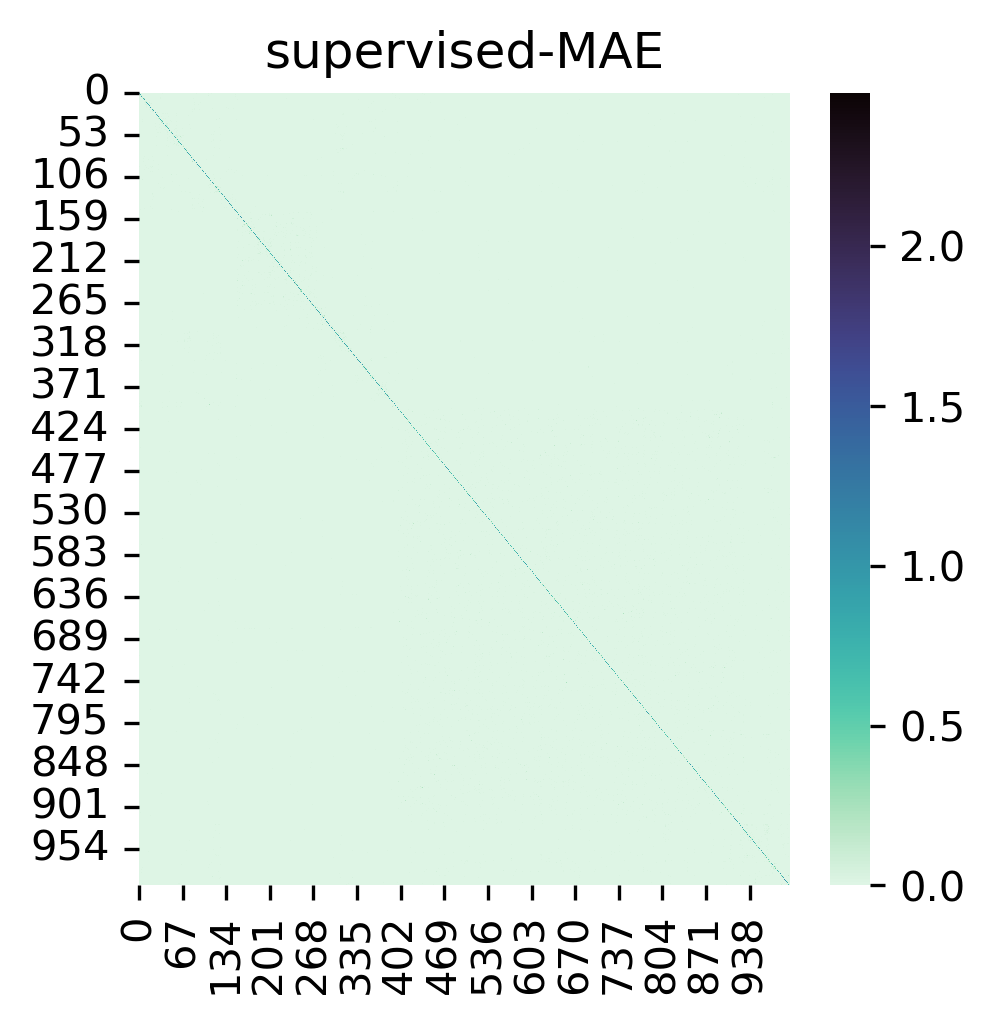

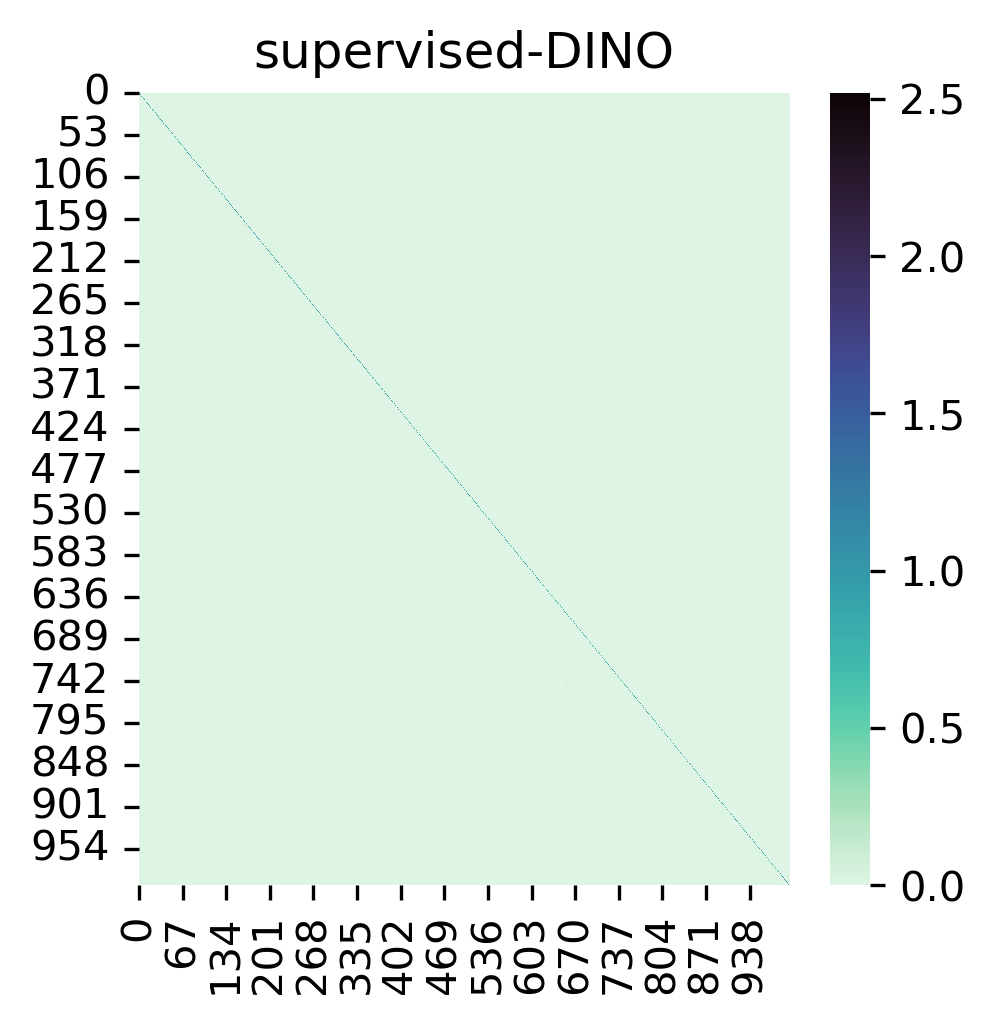

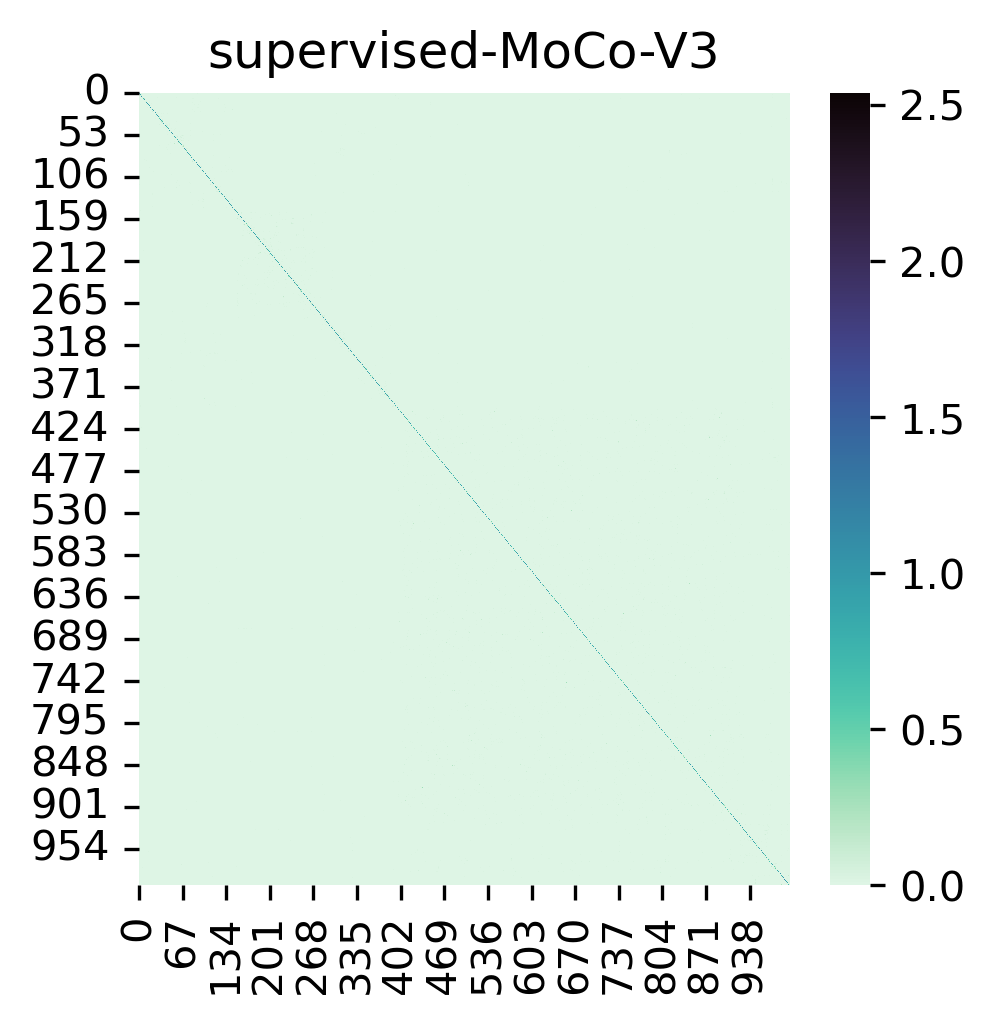

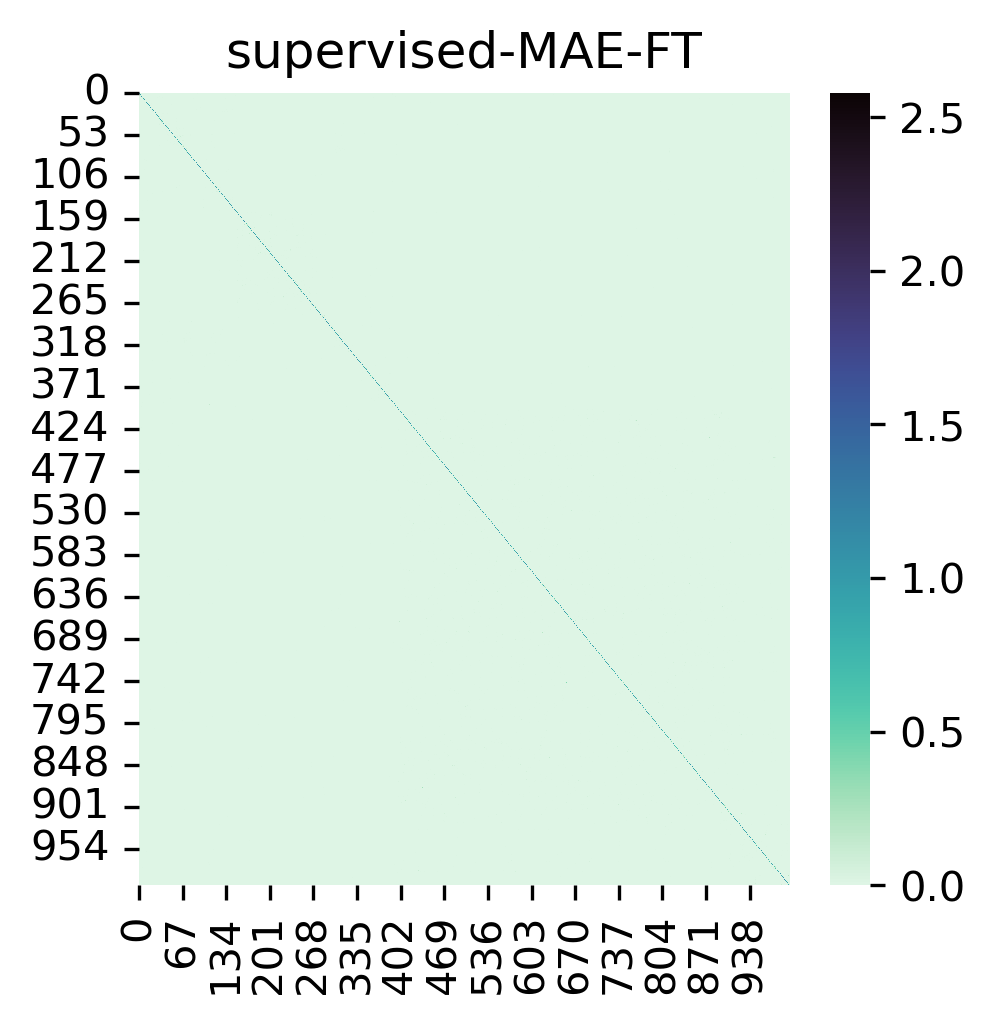

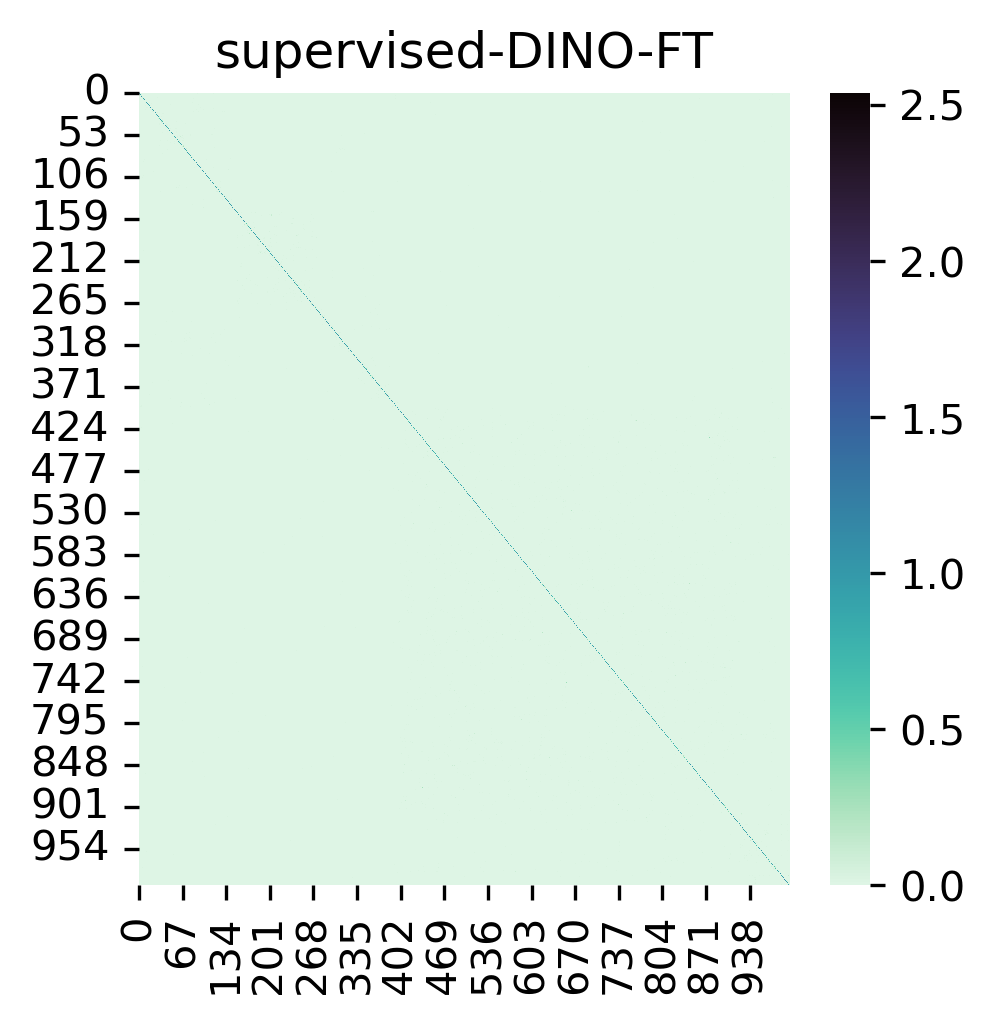

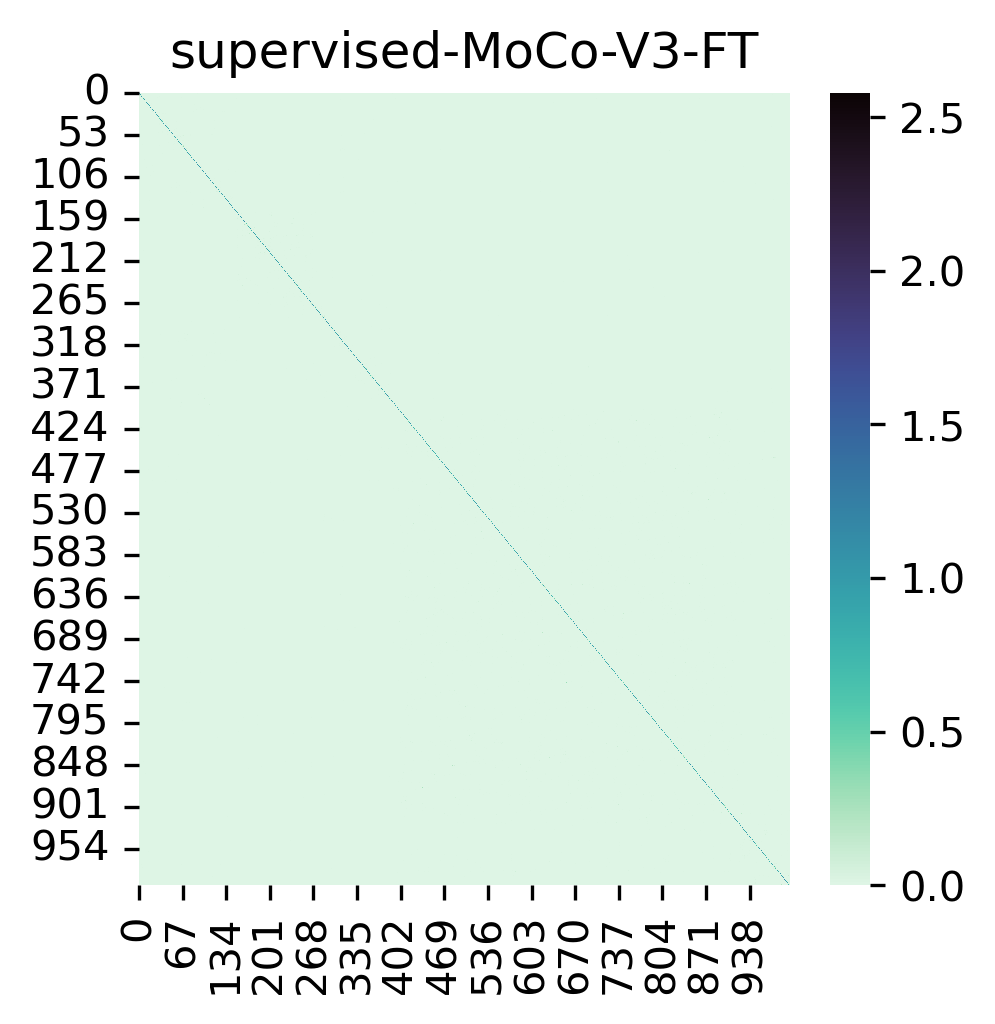

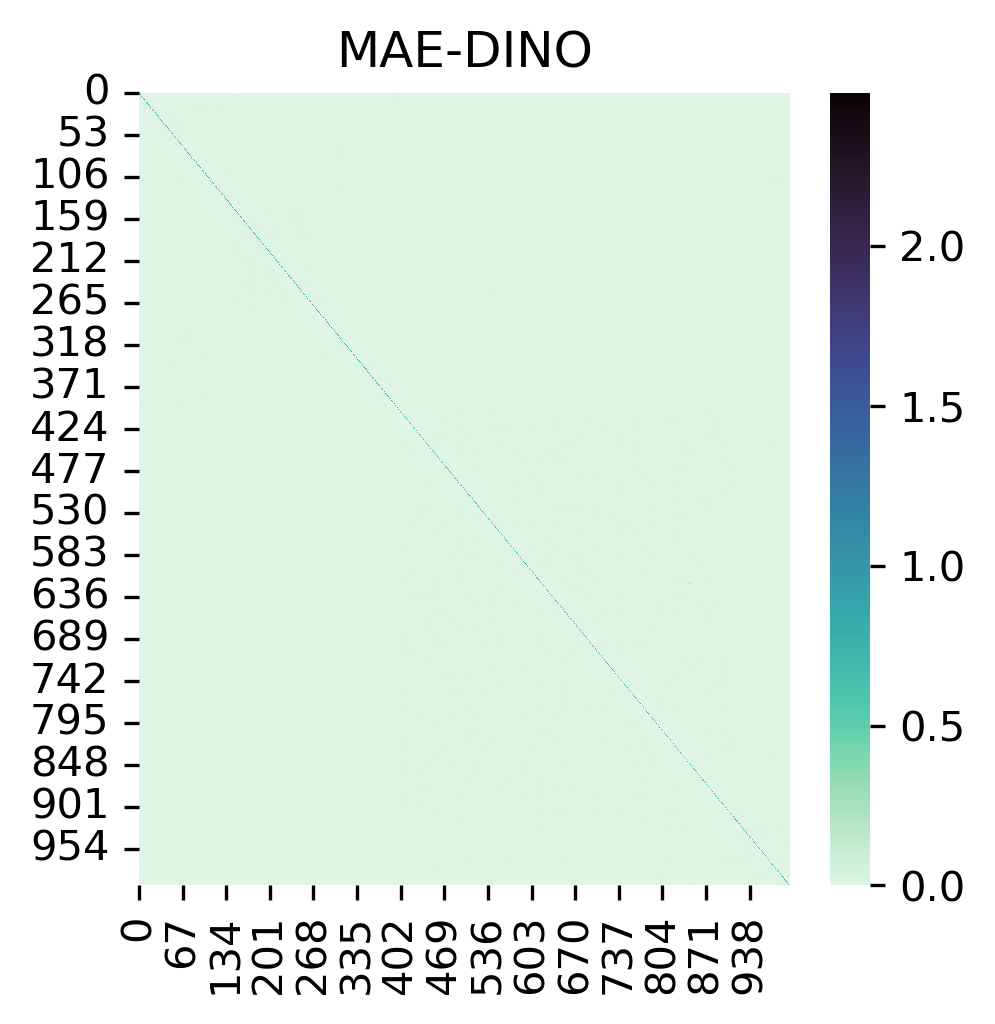

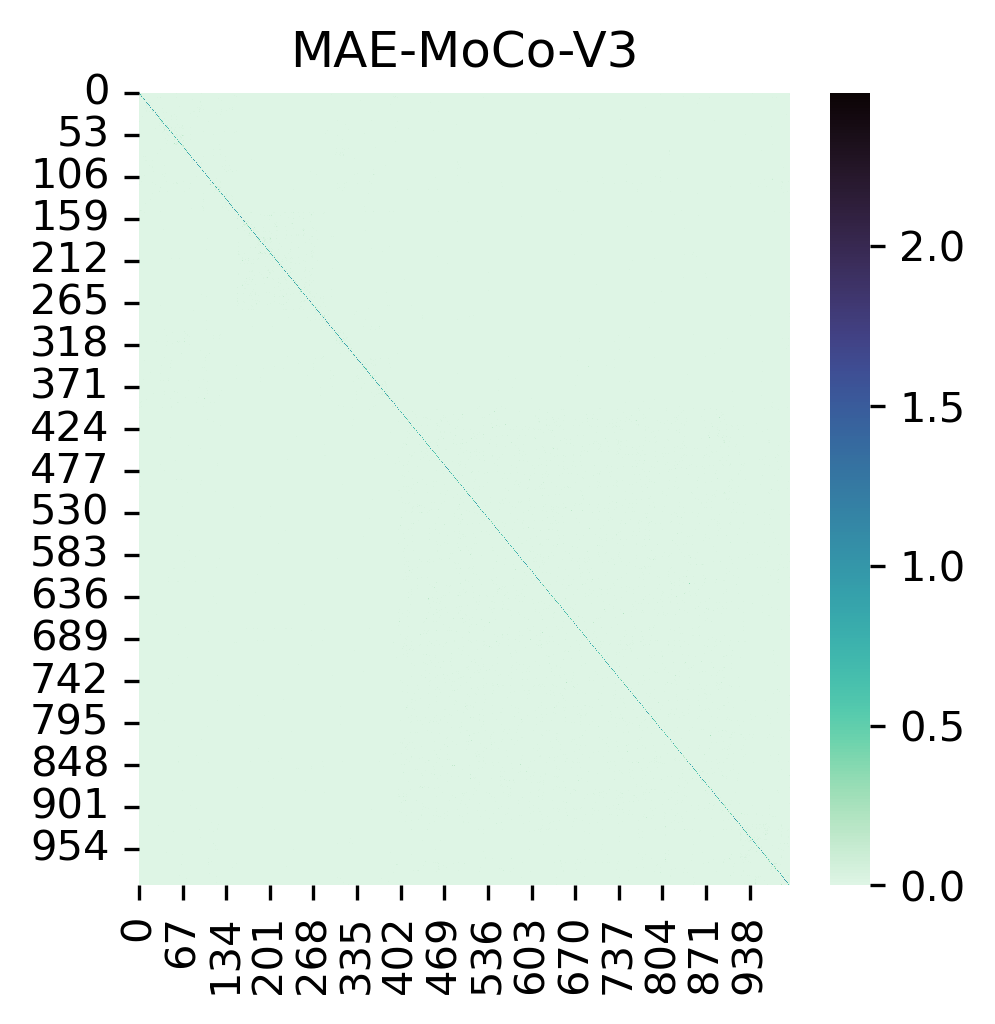

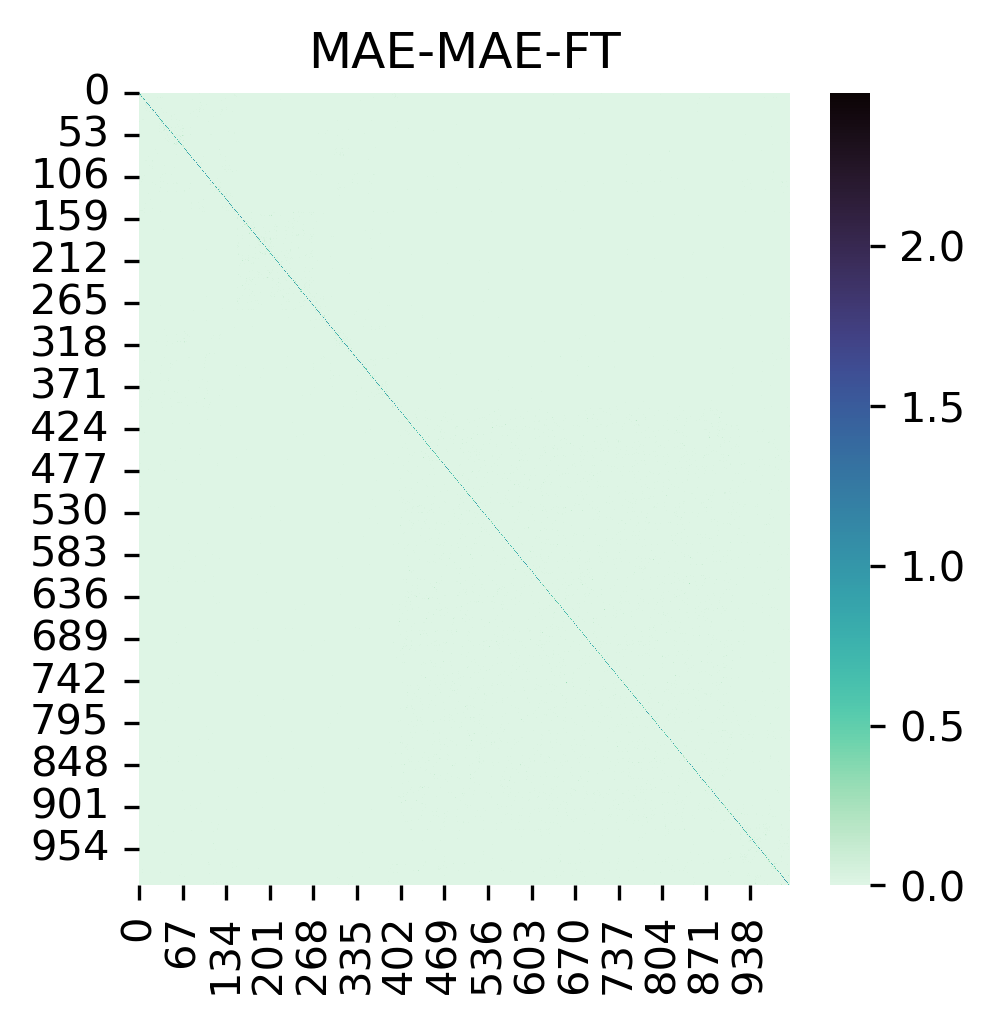

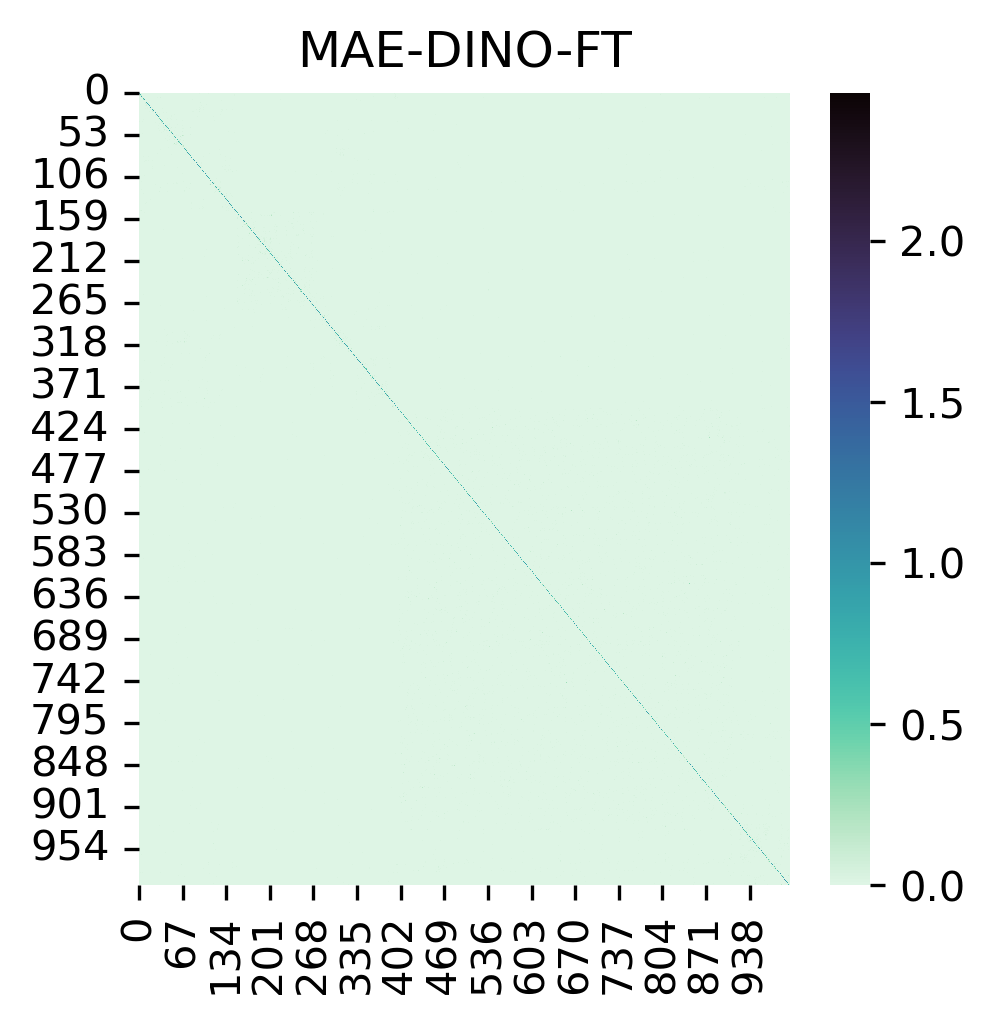

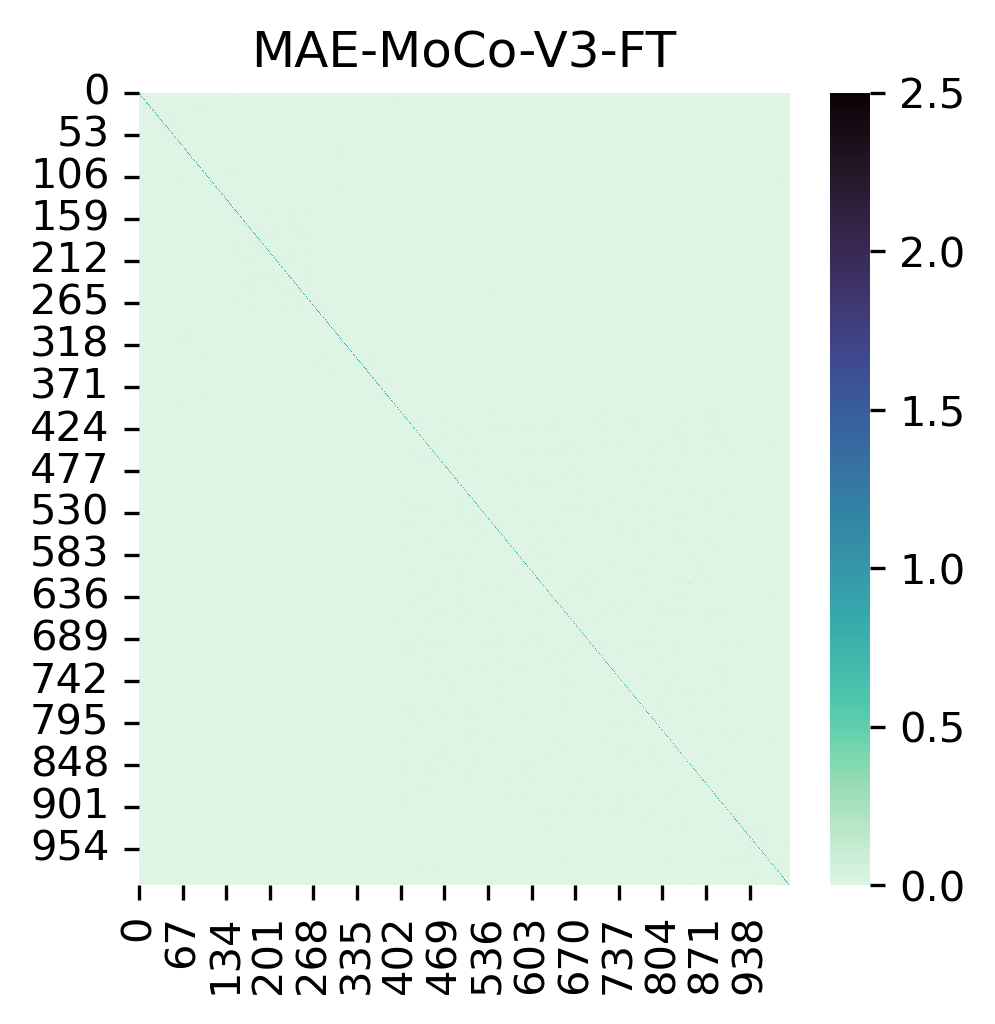

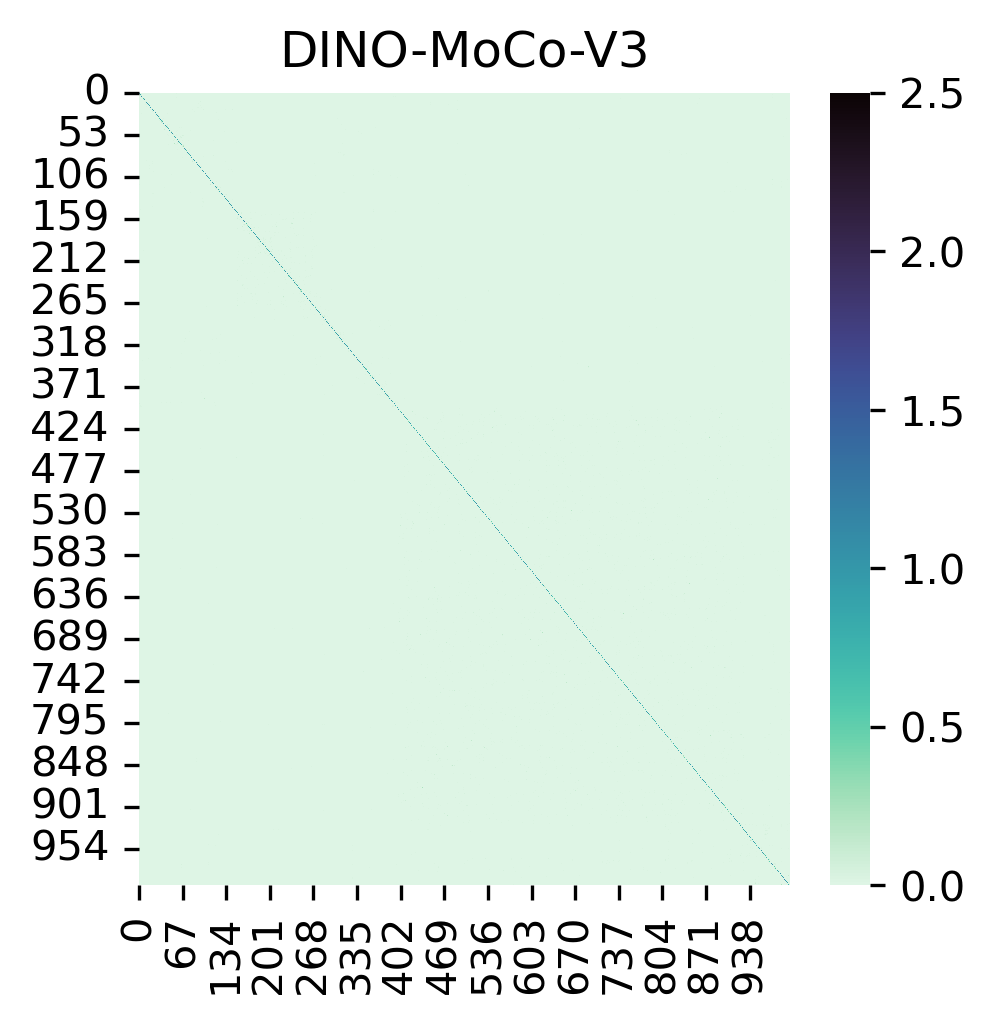

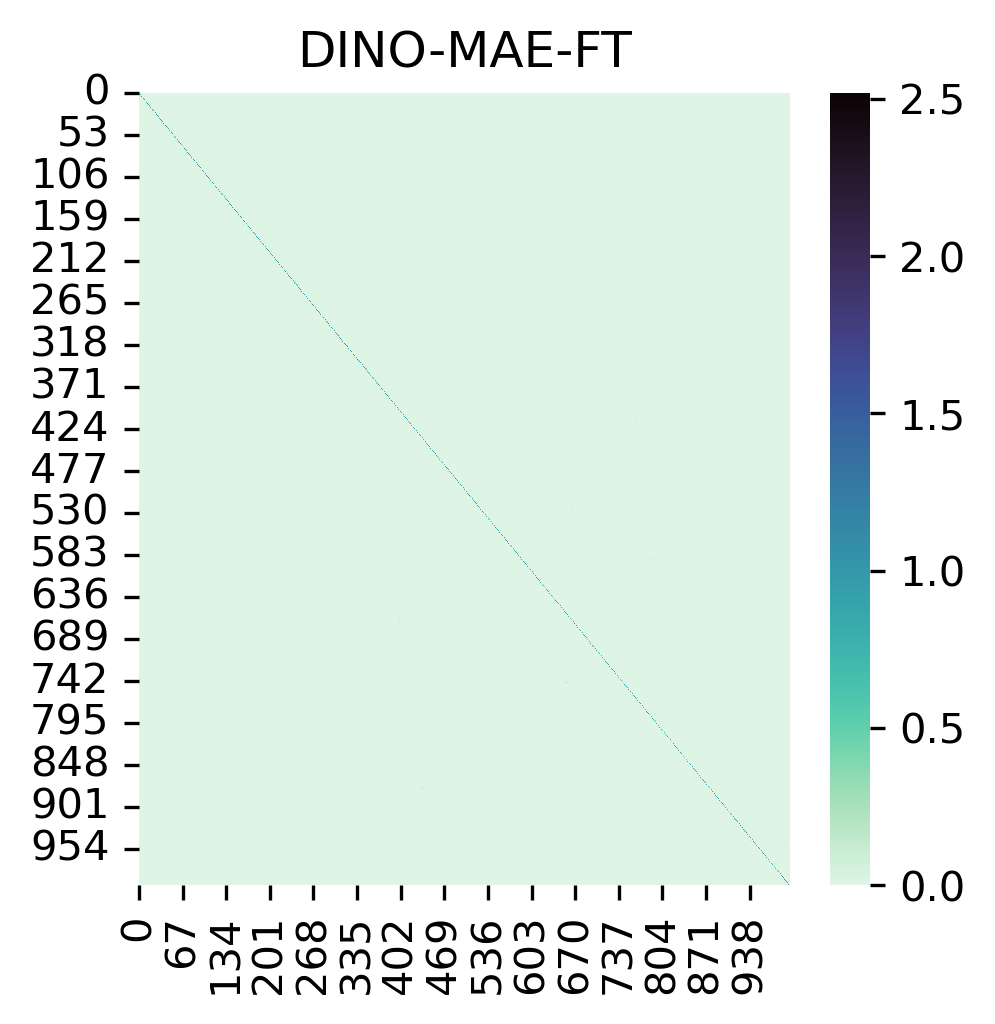

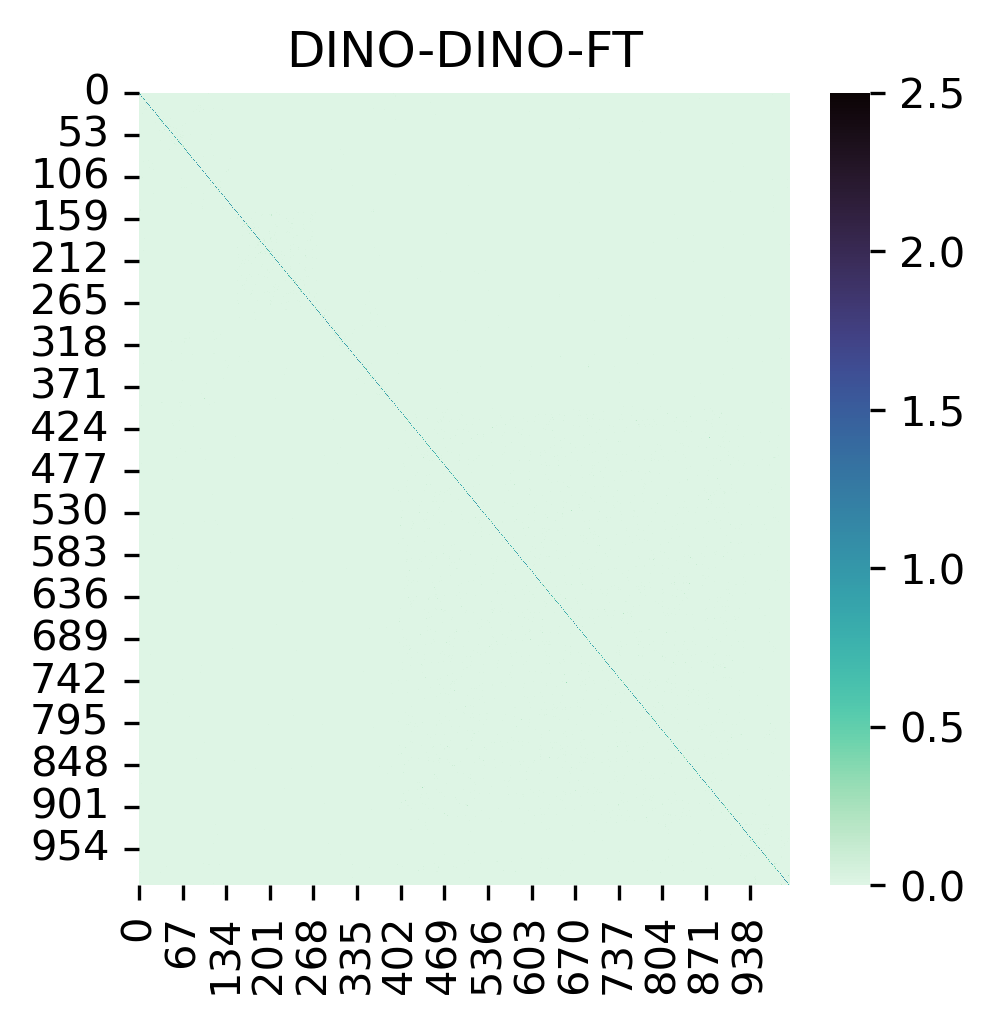

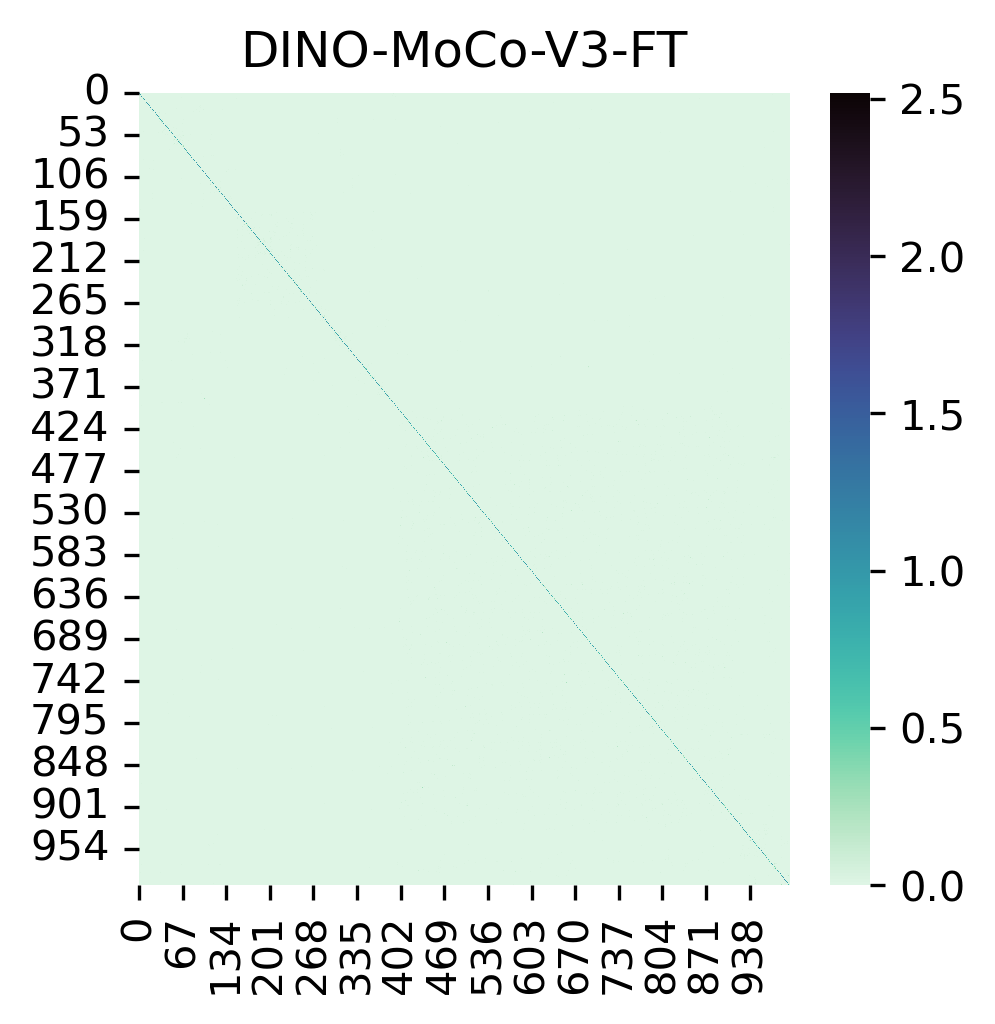

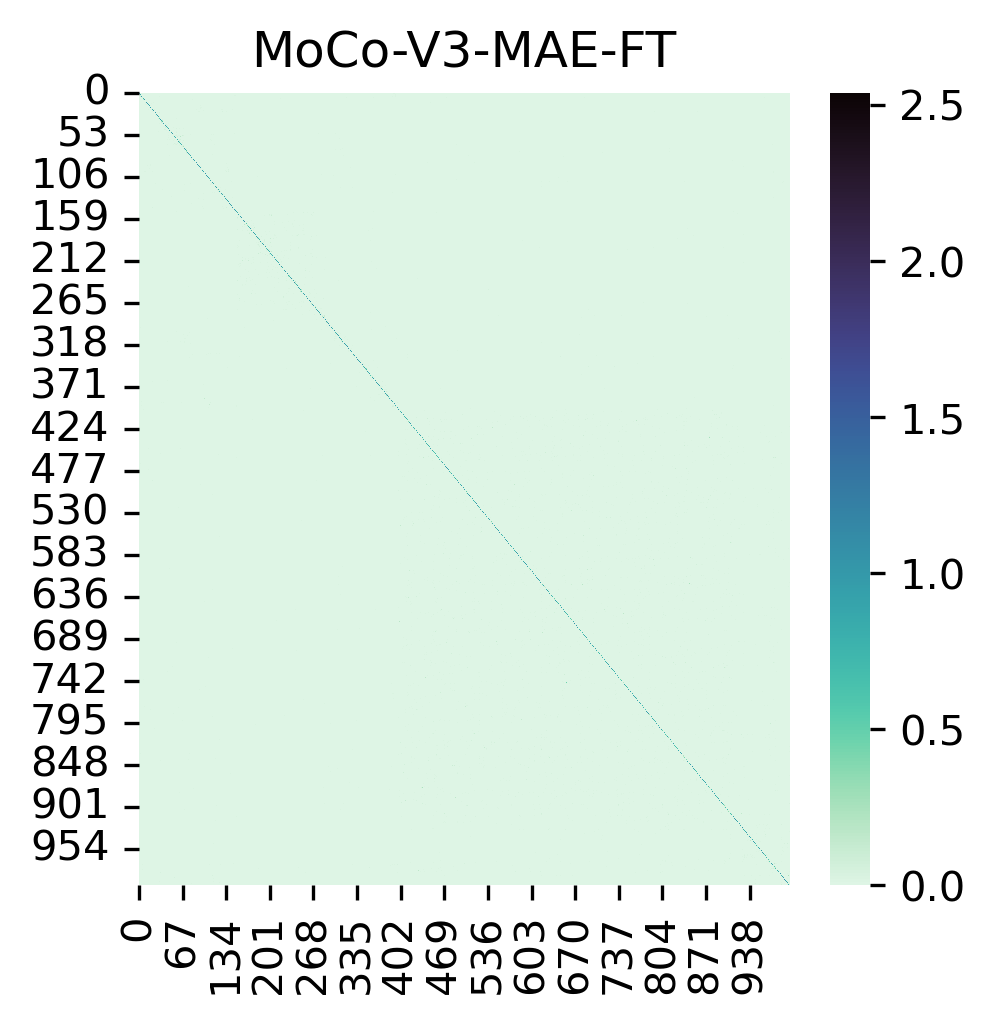

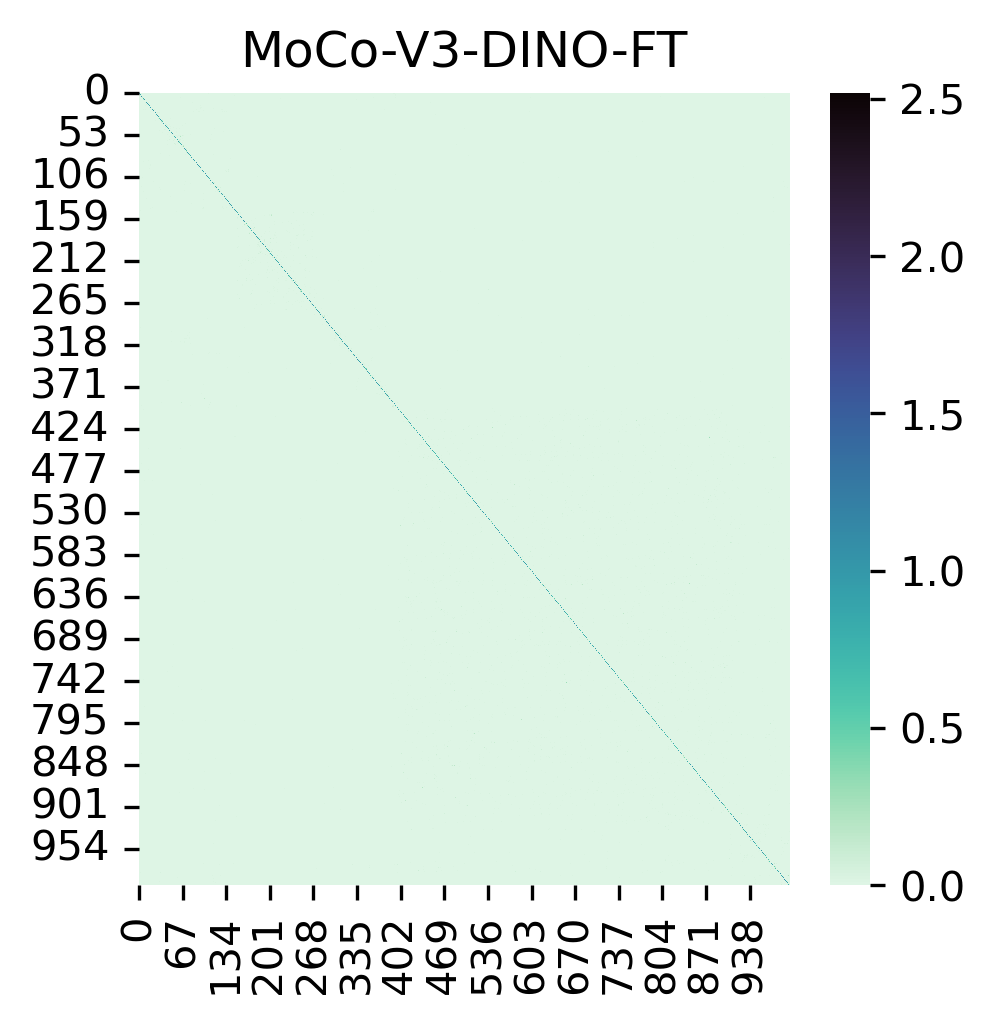

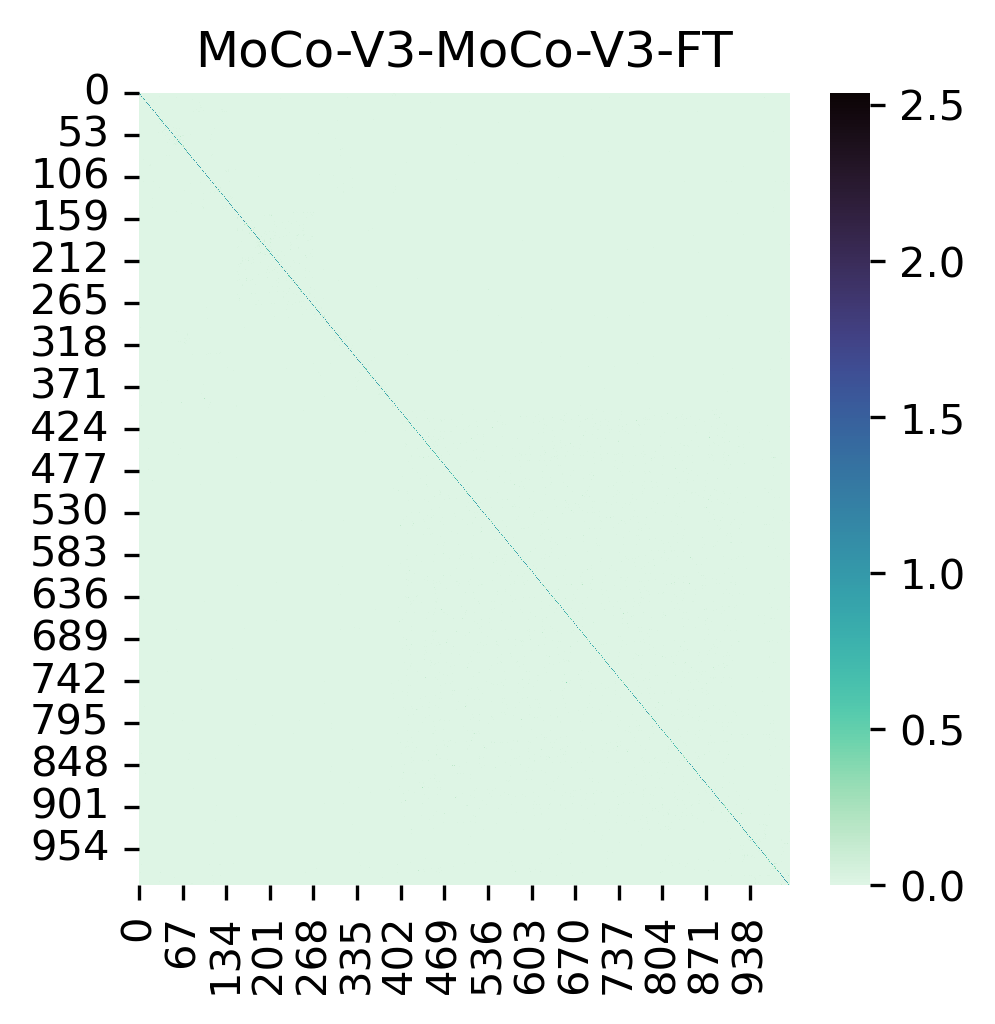

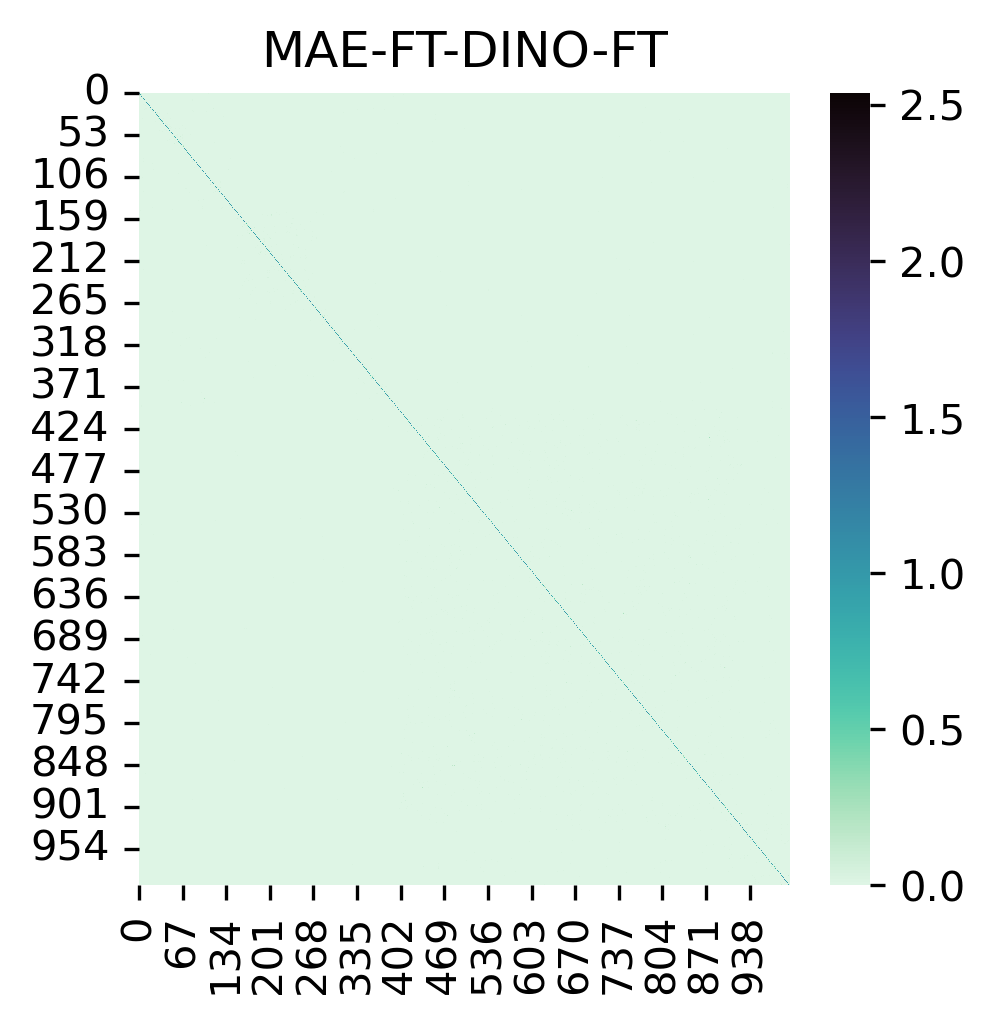

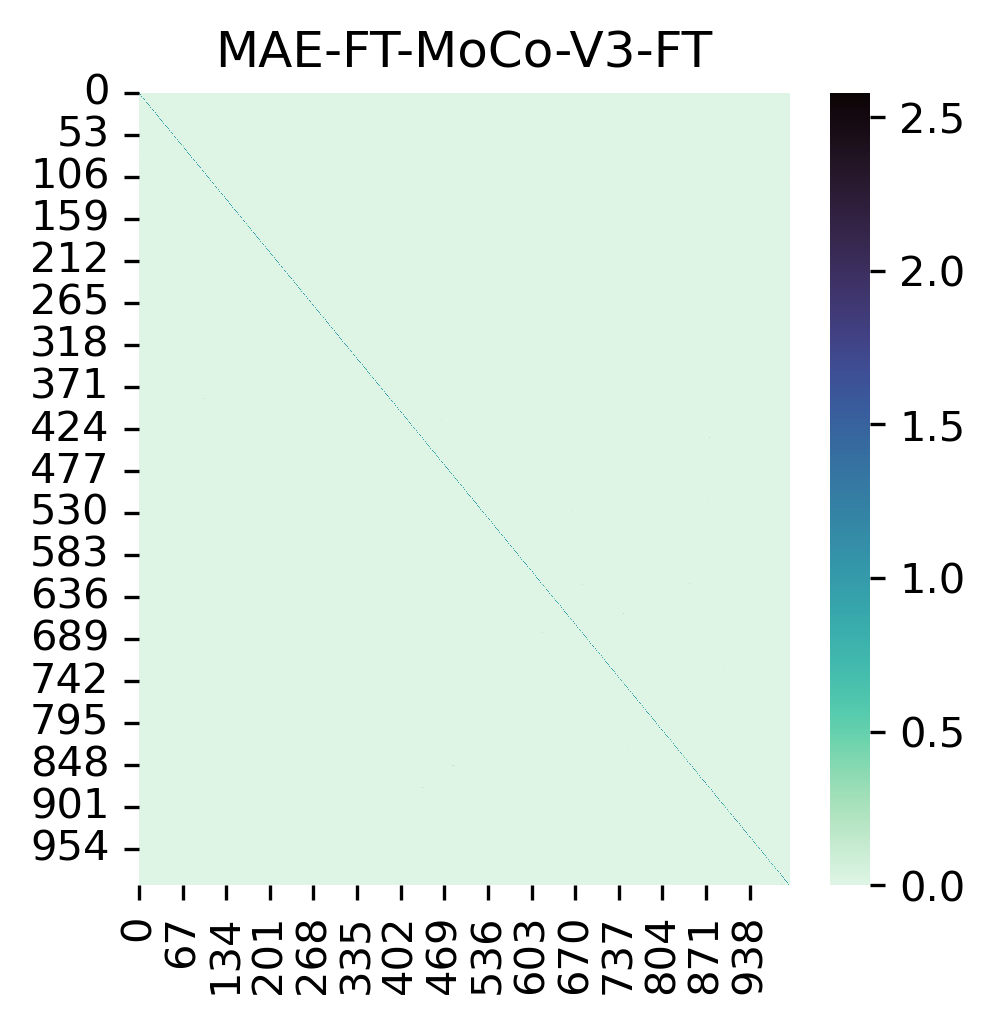

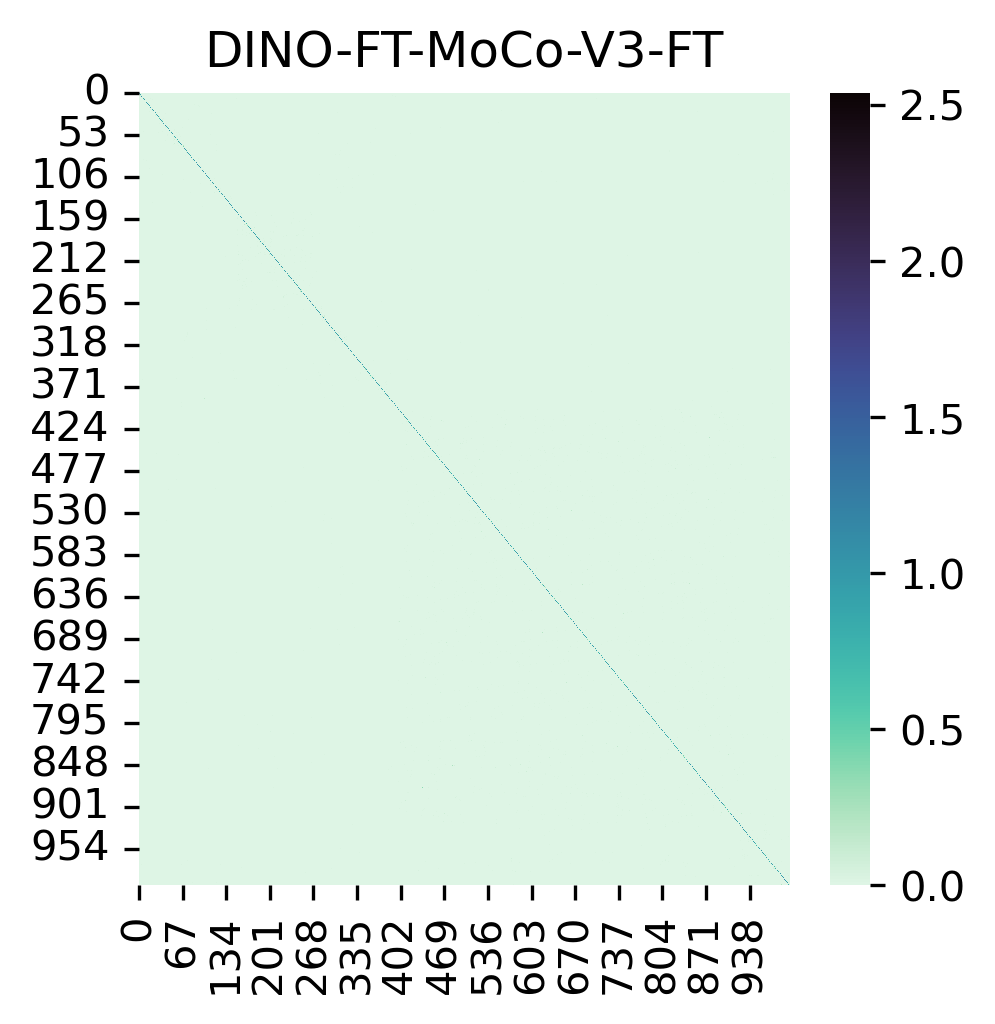

In [15]:
cmap = sns.color_palette("mako_r", as_cmap=True)

for index, key1 in enumerate(keys):
    for key2 in keys[index+1:]:

        fig = figure(figsize=(3.5, 3.5), dpi=300) 

        #matrix_1 = confusion_matrix(labels, dic[key1][1][:, 0])
        matrix = confusion_matrix(dic[key1][1][:, 0], dic[key2][1][:, 0])

        #matrix = np.subtract(matrix_1, matrix_2)
        matrix = np.divide(matrix, 50)
        sns.heatmap(matrix, cmap = cmap)
        plt.title(key1+'-'+key2)
        plt.show()
